# 01 - Exploración inicial de los datos de ensayos clínicos

En este notebook se realiza el análisis exploratorio de los datos(EDA) del conjunto de datos obtenido a partir de la API de ClinicalTrials.gov.

Objetivos:

- Cargar el dataset desde `data/clean/`.
- Verificar la estructura (número de filas, columnas, tipos de datos).
- Analizar valores faltantes.
- Explorar la distribución de variables clave (fase, condición, país, sponsor, etc.).
- Identificar problemas de calidad de datos relevantes para el modelado posterior.


In [1]:
#import os
from pathlib import Path

import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns


# Configuración de gráficos
#plt.style.use("default")
#pd.set_option("display.max_columns", 100)
#sns.set()


In [2]:
PROJECT_ROOT = Path().resolve().parent
DATA_CLEAN_DIR = PROJECT_ROOT / "data" / "clean"

CLEAN_FILENAME = "clinicaltrials_clean.csv"
data_path = DATA_CLEAN_DIR / CLEAN_FILENAME

path = Path(data_path)
if not path.exists():
    raise FileNotFoundError(f"File not found: {path}")
    
if path.suffix.lower() == ".csv":
    df = pd.read_csv(path, low_memory = False)

else:
    raise ValueError(f"Unsupported file extension: {path.suffix}")

In [3]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nSample rows:\n", df.head(5))
print("\nMissing values per column (top 30):")
print(df.isna().sum().sort_values(ascending=False).head(30))


Shape: (204675, 38)

Dtypes:
 NCTId                       object
BriefTitle                  object
OfficialTitle               object
OverallStatus               object
LastKnownStatus             object
StartDate                   object
PrimaryCompletionDate       object
CompletionDate              object
StudyFirstSubmitDate        object
LastUpdateSubmitDate        object
LeadSponsorName             object
LeadSponsorClass            object
BriefSummary                object
Condition                   object
Keyword                     object
StudyType                   object
Phase                       object
DesignAllocation            object
DesignInterventionModel     object
DesignPrimaryPurpose        object
DesignMasking               object
DesignWhoMasked             object
EnrollmentCount            float64
InterventionName            object
PrimaryOutcomeMeasure       object
SecondaryOutcomeMeasure     object
EligibilityCriteria         object
HealthyVolunteers        

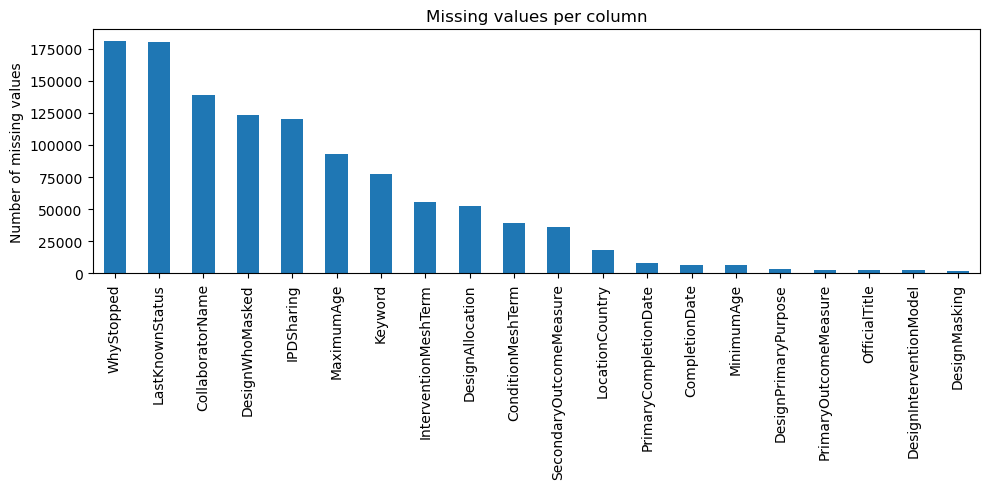

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0].head(20)

if missing.empty:
    print("No missing values found.")

else:
    plt.figure(figsize=(10, 5))
    missing.plot(kind="bar")
    plt.title("Missing values per column")
    plt.ylabel("Number of missing values")
    plt.tight_layout()
    plt.show()

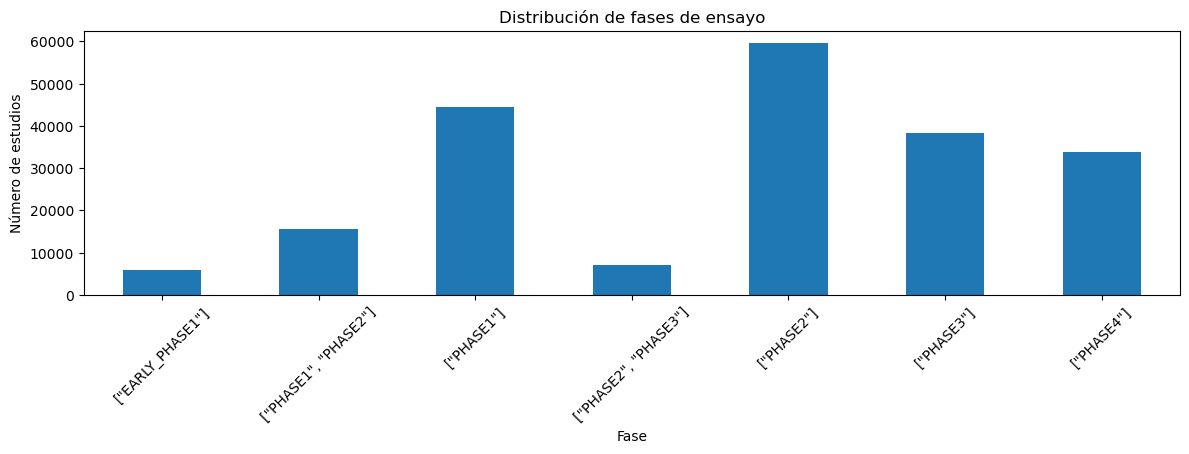

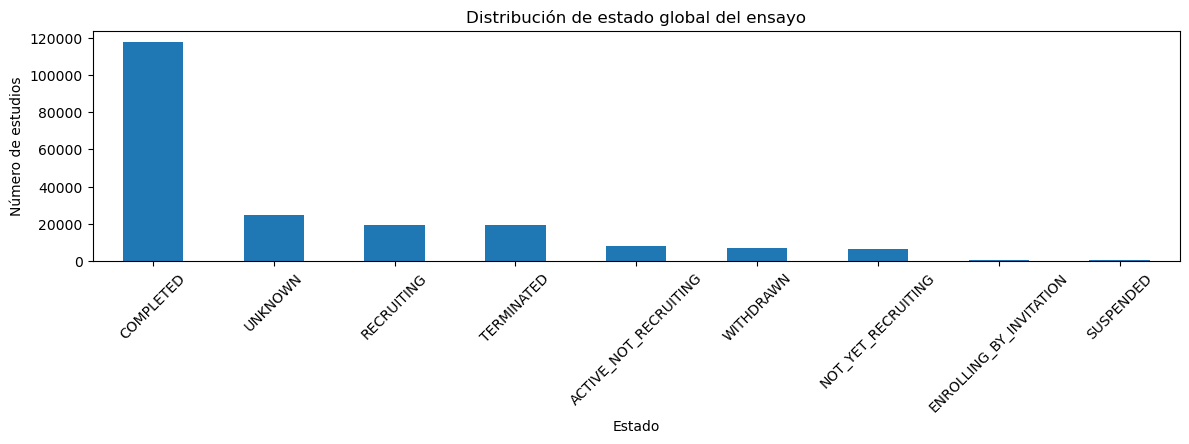

In [5]:
# Fase del ensayo
if "Phase" in df.columns:
    plt.figure(figsize=(12, 5))
    df["Phase"].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Distribución de fases de ensayo")
    plt.xlabel("Fase")
    plt.ylabel("Número de estudios")
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Estado del ensayo 
if "OverallStatus" in df.columns:
    plt.figure(figsize=(12, 5))
    df["OverallStatus"].value_counts(dropna=False).plot(kind="bar")
    plt.title("Distribución de estado global del ensayo")
    plt.xlabel("Estado")
    plt.ylabel("Número de estudios")
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


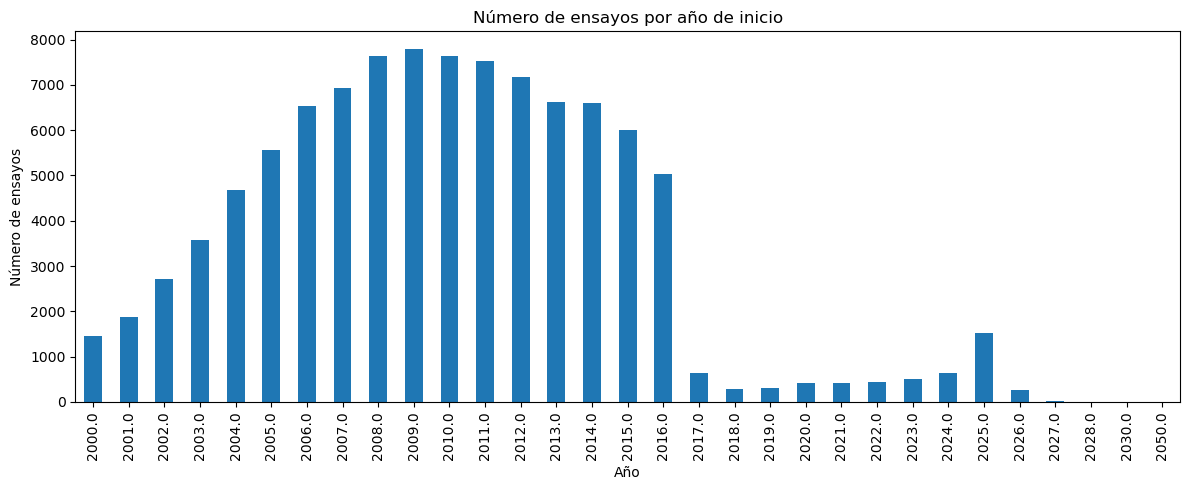

In [6]:
df_date = df.copy()

for col in ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]:
    if col in df_date.columns:
        df_date[col] = pd.to_datetime(df_date[col], errors="coerce")

        
if "StartDate" in df_date.columns:
    plt.figure(figsize=(12, 5))
    df_date["StartDate"].dt.year.value_counts().sort_index().plot(kind="bar")
    plt.title("Número de ensayos por año de inicio")
    plt.xlabel("Año")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.show()


In [7]:
#df = pd.read_csv(path, low_memory = False)

In [8]:
date_columns = ["StartDate", "PrimaryCompletionDate", "CompletionDate", "LastUpdateSubmitDate", "StudyFirstSubmitDate"]


for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()

        quality = pd.Series("full", index=df.index)

        quality[s.isna()] = "missing"
        quality[s.str.len() == 4] = "year_only"
        quality[s.str.len() == 7] = "year_month"

        df[col + "_quality"] = quality

for col in date_columns:
    if col in df.columns:
        s = df[col].astype("string").str.strip()

        # Construimos una copia normalizada
        s_norm = s.copy()

        mask_year = s.str.len() == 4
        mask_year_month = s.str.len() == 7

        s_norm[mask_year] = s_norm[mask_year] + "-01-01"
        s_norm[mask_year_month] = s_norm[mask_year_month] + "-01"

        df[col] = pd.to_datetime(s_norm, errors="coerce")

In [9]:
df["DurationDays"] = (df["PrimaryCompletionDate"] - df["StartDate"]).dt.days

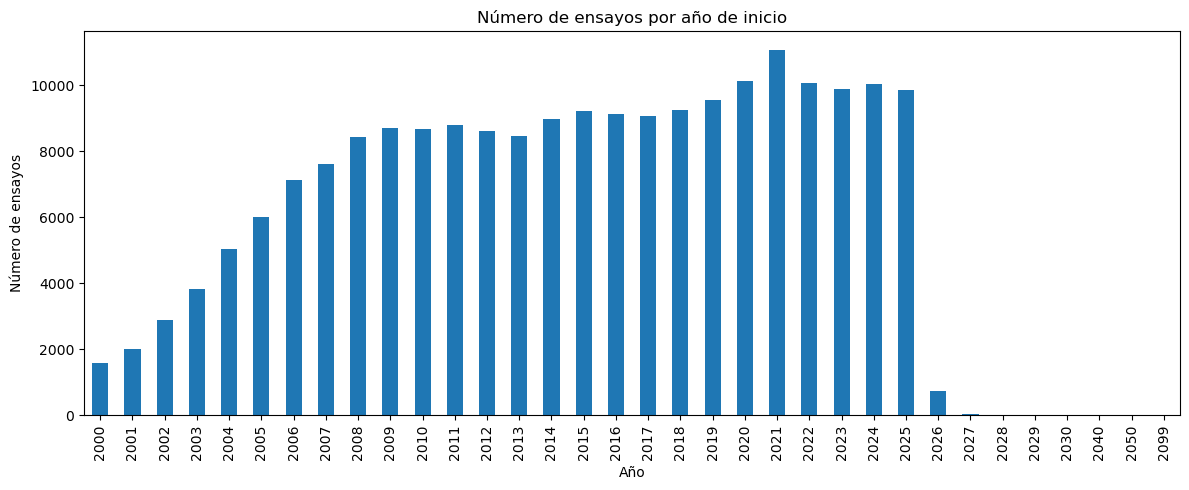

In [10]:
if "StartDate" in df.columns:
    plt.figure(figsize=(12, 5))
    df["StartDate"].dt.year.value_counts().sort_index().plot(kind="bar")
    plt.title("Número de ensayos por año de inicio")
    plt.xlabel("Año")
    plt.ylabel("Número de ensayos")
    plt.tight_layout()
    plt.show()

## Comentarios preliminares

- **Calidad de datos**:
  - [observaciones sobre valores faltantes, duplicados, etc.]

- **Distribución de fases**:
  - desbalance fuerte en ciertas fases

- **Distribución temporal**:
  - desde qué año hay suficientes datos, etc